In [37]:
import qiskit
from scipy.stats import entropy
from scipy.spatial.distance import hamming
import pandas as pd
import copy
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from IPython import display
from itertools import permutations
import math
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict, defaultdict
import random
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.qpy import dump, load
from qiskit_aer import AerSimulator
import csv
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from itertools import product
from qiskit_aer.noise import NoiseModel, depolarizing_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings("ignore", category=RuntimeWarning)
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
def normalize(result):
    total = sum(result.values())
    p_distribution_dict = {k: v / total for k, v in result.items()}
    return p_distribution_dict

In [3]:
def hamming_neighbors(bit_string):
    neighbors = []
    for i in range(len(bit_string)):
        flipped_bit = '1' if bit_string[i] == '0' else '0'
        new_string = bit_string[:i] + flipped_bit + bit_string[i+1:]
        neighbors.append(new_string)
    
    return neighbors

In [4]:
def hamming_decimal(num, bit_length):
    b_str = bin(num)[2:].zfill(bit_length)
    neighbors = hamming_neighbors(b_str)

    for i in range(len(neighbors)):
        neighbors[i] = int(''.join(neighbors[i]), 2)

    return neighbors

In [5]:
# Create a new dict with {bstr: prob}
def newResultDict(test_case):
    dict = {"secret_string":test_case}
    stringArray = ["0"] * len(test_case)
    string = "".join(stringArray)
    while(True):
        dict[string] = 0
        if(string == "1" * len(test_case)):
            break
        for i in range(len(string)):
            if string[i] == "0":
                if string[i+1:].find("0") == -1:
                    stringArray[i] = "1"
                    for v in range(i + 1, len(test_case)):
                        stringArray[v] = "0"
                    string = "".join(stringArray)
                    break
    return dict

In [6]:
# Function to predict the most likely outcome (binary string)
def predict_binary_string(predictions, num_qubits):
    # Get the index of the maximum probability
    max_index = torch.argmax(predictions).item()

    # Convert index to corresponding binary string
    result_string = bin(max_index)[2:].zfill(num_qubits)
    return result_string

In [7]:
# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    total = len(predictions)

    for predicted, true in zip(predictions, ground_truth):
        
        # Compare the predicted binary string with the true label
        if predicted == true:
            correct += 1

    accuracy = correct / total
    return accuracy

In [8]:
def dec_to_countsVec(decimal, n_qubits, n_shots):
    res = [0] * (2**n_qubits)
    res[decimal] = n_shots
    return res

In [9]:
def hamming(s1, s2):
    assert len(s1) == len(s2), "The lengths of the binary strings must be equal."

    # Calculate the Hamming distance by counting the positions where the characters are different
    distance = sum(c1 != c2 for c1, c2 in zip(s1, s2))

    return distance

In [10]:
def hamming_bin(binary_string, shots, counts):
    # true_result = list(binary_string)
    hamming_Count = defaultdict(int)
    hamming_Probs = defaultdict(int)
    neighbor_list = {}
    bin_props = {}

    for obs_str, count in counts.items():
        hamming_dist = int(hamming(obs_str, binary_string))
        hamming_Count[hamming_dist] += count
        hamming_Probs[hamming_dist] = (hamming_Count[hamming_dist] / shots)
        if hamming_dist in neighbor_list:
            neighbor_list[hamming_dist].append(obs_str)
        else:
            neighbor_list[hamming_dist] = [obs_str]
        bin_props[obs_str] = (count/shots)

    for h_dist, count  in hamming_Count.items():
        hamming_Count[h_dist] = count/len(neighbor_list[h_dist])

    for h_dist, prob in hamming_Probs.items():
        hamming_Probs[h_dist] = prob/len(neighbor_list[h_dist])

    neighbor_list = dict(sorted(neighbor_list.items()))
    hamming_Count = dict(sorted(hamming_Count.items()))
    hamming_Probs = dict(sorted(hamming_Probs.items()))
    bin_props = dict(sorted(bin_props.items()))
    counts = dict(sorted(counts.items()))

    return hamming_Count, hamming_Probs, bin_props, counts, neighbor_list

In [11]:
def plot_distribution(distribution, target=None, window=30):
    distribution = np.array(distribution)
    x = np.arange(len(distribution))

    if target is not None and 0 <= target < len(distribution):
        start = max(target - window // 2, 0)
        end = min(target + window // 2 + 1, len(distribution))
        x = x[start:end]
        distribution = distribution[start:end]
        colors = ['skyblue'] * len(distribution)
        colors[target - start] = 'red'
    else:
        colors = ['skyblue'] * len(distribution)

    plt.figure(figsize=(12, 5))
    plt.bar(x, distribution, color=colors)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Zoomed Distribution Around Target")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def get_rank(data_dict, target):
    # Convert dict items to a list of (bit_string, value) pairs
    items = list(data_dict.items())
    # Sort by value in descending order
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    
    # Create a mapping from bit string to rank (1-based)
    rank_map = {bit: rank+1 for rank, (bit, _) in enumerate(sorted_items)}
    
    # Return the rank of the target bit string
    return rank_map.get(target, None)  # Returns None if target not in dict


In [13]:
def fid_class(dist_a, dist_b):
    """
    Calculate the fidelity between two probability distributions.

    Args:
        dist_a (list): The first probability distribution.
        dist_b (list): The second probability distribution.

    Returns:
        float: The fidelity between the two distributions.
    """
    fid = 0

    for a, b in zip(dist_a, dist_b):
        # Calculate the square root of the product of corresponding elements in the distributions
        fid += np.sqrt(a * b)
    return fid

Data preparation for model training

In [14]:
n = 9
key_list = []
result_bank = []

file_name = f'1_7-ones_9qubitsBV.csv'
with open(file_name, 'r', newline='') as csvfile:
    resultDict = newResultDict("0" * n)
    reader = csv.DictReader(csvfile, fieldnames = resultDict.keys())
    for row in reader:
        key_list.append(row['secret_string'])
        result_bank.append({k: int(v) for k, v in list(row.items())[1:]})

data_dicts = []
for i in range(len(key_list)):
    temp = {}
    temp["input"] = result_bank[i]
    temp["target"] = key_list[i]
    data_dicts.append(temp)


In [15]:
rank_list = []
for i in range(len(data_dicts)):
    rank_list.append(get_rank(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list = np.array(rank_list)
rank_list

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,
        4,  1,  2,  1,  1,  1,  1,  1,  3,  1,  1,  1, 65,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3, 52,  1,  1,  1,  1,  1,
        5,  1,  3,  1,  2,  1,  3,  1,  1, 26, 50,  1,  1,  1,  1,  1,  7,
        1,  5,  1,  2,  5,  3,  1,  4, 13, 18,  1,  1,  1,  1,  2, 15,  2,
       29,  2,  2,  7, 19,  1, 11, 15, 30,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  8,  1,  1,  2,  7,  1,  1,  1,  1,  1])

In [16]:
hamming_data = []
for i in range(len(data_dicts)):
    a, b, c, d, e = hamming_bin(data_dicts[i]['target'], 10240, data_dicts[i]['input'])
    hamming_data.append((a,b,c,d,e))

In [17]:
sum = [0] * 9
for i in range(len(hamming_data)):
    for j in range(len(sum)):
        sum[j] += hamming_data[i][1][j]

avg = []
for i in sum:
    avg.append(i/len(hamming_data))

In [18]:
avg

[0.4438745281040269,
 0.025969352978187914,
 0.003978927805741985,
 0.0011313175385506552,
 0.00041772572773516567,
 0.00017831862715723883,
 8.549993508309364e-05,
 4.4258453346383303e-05,
 2.621644295302013e-05]

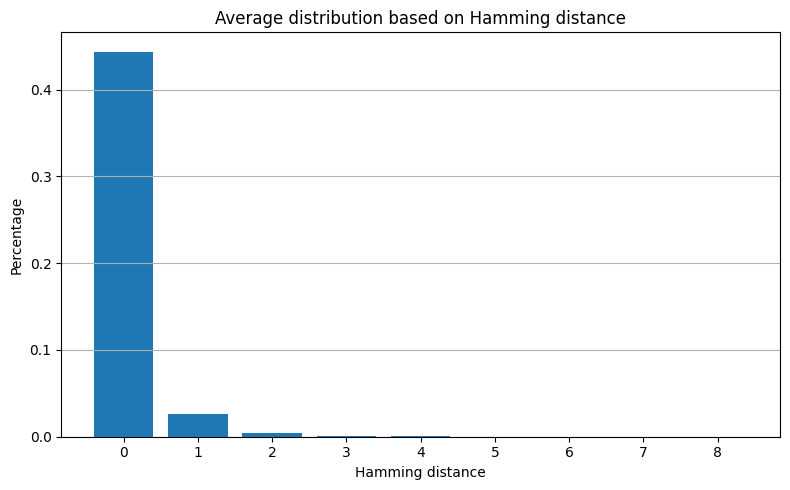

In [19]:
# Plotting the histogram
plt.figure(figsize=(8, 5))
plt.bar(range(len(avg)), avg, tick_label=[f'{i}' for i in range(len(avg))])
plt.xlabel('Hamming distance')
plt.ylabel('Percentage')
plt.title('Average distribution based on Hamming distance')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
X = []
y = []
for i in range(len(data_dicts)):
    X.append([j for j in data_dicts[i]['input'].values()])
    y.append(data_dicts[i]['target'])

X = np.array(X)
X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
X_tensor = torch.tensor(X, dtype=torch.float32)

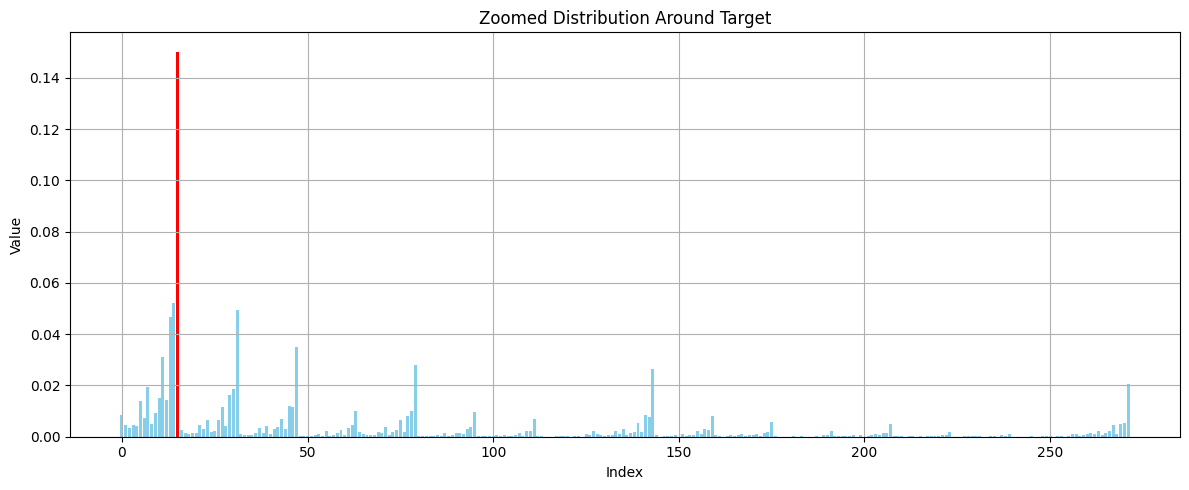

In [21]:
plot_distribution(X[15], int(y[15], 2), window=len(X[15]))

In [22]:
original_predict = []
for i in range(len(X_tensor)):
    predicted_string = predict_binary_string(X_tensor[i], num_qubits=9)
    original_predict.append(predicted_string)
calculate_accuracy(original_predict, y)

0.7516778523489933

In [23]:
for i in range(len(y)):
    y[i] = dec_to_countsVec(int(y[i],2), n, 10240)

y = np.array(y)
y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
y_tensor = torch.tensor(y, dtype=torch.float32)

In [24]:
# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Automatically extract input/output dimensions from the dataset
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]

In [25]:
X_tensor.shape, y_tensor.shape, input_dim, output_dim

(torch.Size([149, 512]), torch.Size([149, 512]), 512, 512)

In [26]:
y_tensor.shape

torch.Size([149, 512])

Model

In [27]:
class HammingConvLayer(nn.Module):
    def __init__(self, input_dim, output_dim, kernel):
        super(HammingConvLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel = nn.Parameter(torch.tensor(kernel, dtype=torch.float32, device='cuda'))
        assert len(kernel) == 10, "Kernel size must be 10 (1 for self-connection, 9 for Hamming neighbors)"
    
    def hamming_neighbors(self, index):
        """Generate indices of Hamming distance-1 neighbors, ensuring valid indices and sorting them."""
        neighbors = []
        bit_length = (self.input_dim - 1).bit_length()  # Dynamically determine bit length
        binary_str = format(index, f'0{bit_length}b')
        for i in range(len(binary_str)):
            flipped = list(binary_str)
            flipped[i] = '1' if flipped[i] == '0' else '0'
            neighbor_index = int(''.join(flipped), 2)
            if neighbor_index < self.output_dim:  # Ensure within valid range
                neighbors.append(neighbor_index)
        neighbors = sorted(neighbors)  # Sort neighbors before returning
        return neighbors
    
    def forward(self, input_data):
        input_data = input_data.to('cuda')
        output_data = torch.zeros_like(input_data, device='cuda')
        
        for i in range(self.input_dim):
            neighbors = self.hamming_neighbors(i)
            result = input_data[:, i] * self.kernel[0]
            for j, neighbor in enumerate(neighbors):
                if neighbor < self.input_dim:  # Ensure valid feature index
                    if j+1 < len(self.kernel):  # Ensure valid kernel indexing
                        result += input_data[:, neighbor] * self.kernel[j+1]

            # Apply ReLU activation function
            output_data[:, i] = torch.relu(result)  # Assign batch-wise

        return output_data  # No softmax applied at this stage


In [28]:
class HammingConvModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, kernel_list):
        super(HammingConvModel, self).__init__()
        self.layers = nn.ModuleList([
            HammingConvLayer(input_dim, output_dim, torch.tensor(kernel_list[i], dtype=torch.float32, device='cuda'))
            for i in range(num_layers)
        ])
    
    def forward(self, input_data):
        input_data = input_data.to('cuda')
        for layer in self.layers:
            input_data = layer(input_data)  # Pass through layers
        
        # Apply softmax only at the final layer
        exp_values = torch.exp(input_data - torch.max(input_data))
        return exp_values / torch.sum(exp_values, dim=1, keepdim=True)
    
    def train_model(self, train_loader, test_loader, learning_rate=0.01, epochs=50):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_fn = nn.KLDivLoss(reduction='batchmean')
        kernel_history = []
        loss_history = []
        train_accuracy_history = []
        test_loss_history = []
        test_accuracy_history = []

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                optimizer.zero_grad()
                predicted_output = self.forward(X_batch)
                predicted_log = torch.log(predicted_output + 1e-9)
                loss = loss_fn(predicted_log, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                preds = predicted_output.argmax(dim=1)
                labels = y_batch.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += y_batch.size(0)

            avg_loss = epoch_loss / len(train_loader)
            train_acc = correct / total * 100
            loss_history.append(avg_loss)
            train_accuracy_history.append(train_acc)

            # ---- Evaluation on test set ----
            self.eval()
            total_test_loss = 0.0
            total_test_correct = 0
            total_test_samples = 0

            with torch.no_grad():
                for X_test, y_test in test_loader:
                    X_test, y_test = X_test.to('cuda'), y_test.to('cuda')
                    test_output = self.forward(X_test)
                    test_log_output = torch.log(test_output + 1e-9)
                    test_loss = loss_fn(test_log_output, y_test)
                    total_test_loss += test_loss.item()

                    test_preds = test_output.argmax(dim=1)
                    test_labels = y_test.argmax(dim=1)
                    total_test_correct += (test_preds == test_labels).sum().item()
                    total_test_samples += y_test.size(0)

            avg_test_loss = total_test_loss / len(test_loader)
            avg_test_acc = total_test_correct / total_test_samples * 100
            test_loss_history.append(avg_test_loss)
            test_accuracy_history.append(avg_test_acc)

            print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.6f}, Train Acc: {train_acc:.2f}% | Test Loss: {avg_test_loss:.6f}, Test Acc: {avg_test_acc:.2f}%")

            # Optional: store kernel values
            kernel_snapshot = [layer.kernel.detach().cpu().tolist() for layer in self.layers]
            kernel_history.append(kernel_snapshot)

        # ---- Plotting ----
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label='Train Loss')
        plt.plot(test_loss_history, label='Test Loss')
        plt.plot(train_accuracy_history, label='Train Accuracy')
        plt.plot(test_accuracy_history, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate the model on a test set."""
        self.eval()  # Set model to evaluation mode
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        loss_fn = nn.KLDivLoss(reduction='batchmean')
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predicted_output = self.forward(X_batch)
                predicted_output = torch.log(predicted_output + 1e-9)  # Convert to log-space
                loss = loss_fn(predicted_output, y_batch)
                total_loss += loss.item()
                
                softmax_output = torch.exp(predicted_output)  # Convert log-space back to probabilities
                total_correct += (softmax_output.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
                total_samples += y_batch.size(0)
        
        avg_loss = total_loss / len(test_loader)
        accuracy = total_correct / total_samples * 100
        print(f"Evaluation Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%")
        return avg_loss, accuracy
    
    def plot_kernel_changes(self, kernel_history):
        """Visualize how the kernel values evolve over training epochs."""
        num_epochs = len(kernel_history)
        num_layers = len(self.layers)
        fig, axes = plt.subplots(num_layers, 1, figsize=(10, 5 * num_layers))
        
        if num_layers == 1:
            axes = [axes]
        
        for layer_idx in range(num_layers):
            kernels = [epoch[layer_idx] for epoch in kernel_history]
            kernels = torch.tensor(kernels)
            
            for i in range(kernels.shape[1]):  # Loop through kernel weights
                axes[layer_idx].plot(range(num_epochs), kernels[:, i], label=f'Weight {i}')
            
            axes[layer_idx].set_title(f'Layer {layer_idx + 1} Kernel Evolution')
            axes[layer_idx].set_xlabel('Epochs')
            axes[layer_idx].set_ylabel('Kernel Values')
            axes[layer_idx].legend()
        
        plt.tight_layout()
        plt.show()


In [29]:
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [30]:
def load_model(model_class, input_dim, output_dim, num_layers, kernel_list, file_path):
    model = model_class(input_dim, output_dim, num_layers, kernel_list)
    model.load_state_dict(torch.load(file_path))
    model.to('cuda')
    model.eval()
    print(f"Model loaded from {file_path}")
    return model

In [31]:
def evaluate_model(model, test_loader):
    """Evaluate the model and print predictions vs true values with bit string representation and accuracy."""
    model.eval()
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predicted_output = model(X_batch)
            predicted_indices = torch.argmax(predicted_output, dim=1).cpu().numpy()
            true_indices = torch.argmax(y_batch, dim=1).cpu().numpy()
            
            print("Predictions (Bit Strings & Decimal, Top 10 Closest):")
            for i, idx in enumerate(predicted_indices):
                top_10_indices = torch.topk(predicted_output[i], 10).indices.cpu().numpy()
                top_10_bit_strings = [format(t, '09b') for t in top_10_indices]
                top_10_decimals = [str(t) for t in top_10_indices]
                print(f"Predicted: {format(idx, '09b')} (Decimal: {idx})")
                print(f"Top 10 Closest: {', '.join(top_10_bit_strings)} (Decimals: {', '.join(top_10_decimals)})")
            
            print("True Values (Bit Strings & Decimal):")
            for idx in true_indices:
                bit_str = format(idx, '09b')
                print(f"{bit_str} (Decimal: {idx})")
            
            # Compute accuracy
            correct_predictions += (predicted_indices == true_indices).sum()
            total_samples += y_batch.size(0)
    
    print(f"Accuracy: {100 * correct_predictions / total_samples:.2f}%")
    print("-" * 50)

In [32]:
kernel = [0] * (n+1)
kernel[0] = avg[0]
for i in range(1, len(kernel)):
    kernel[i] = avg[1]
    
# Extract input and output dimensions
input_dim = X_tensor.shape[1]  # 512
output_dim = y_tensor.shape[1]  # 512
num_layers = 4  # Define the number of convolutional layers

# Initialize kernel with average hamming distance weight 
kernel_list = [kernel] * num_layers

In [33]:
kernel_list

[[0.4438745281040269,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914],
 [0.4438745281040269,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914],
 [0.4438745281040269,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914],
 [0.4438745281040269,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914,
  0.025969352978187914]]

In [ ]:
# Create the model and move it to GPU
# model = HammingConvModel(input_dim, output_dim, num_layers, kernel_list).to('cuda')

In [ ]:
# Train the model
# model.train_model(train_loader, learning_rate=0.01, epochs=50)

In [ ]:
# model.evaluate(test_loader)

In [ ]:
# file_path="hamming_conv_model_2.pth"

In [ ]:
# save_model(model, file_path)

In [ ]:
# model = load_model(HammingConvModel, input_dim, output_dim, num_layers, kernel_list, file_path)

In [ ]:
# evaluate_model(model, test_loader)

Run with different train/test split of data:

/tmp/ipykernel_354283/2968998948.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel = nn.Parameter(torch.tensor(kernel, dtype=torch.float32, device='cuda'))


Epoch 1 | Train Loss: 6.179751, Train Acc: 71.43% | Test Loss: 6.071926, Test Acc: 90.00%
Epoch 2 | Train Loss: 5.943831, Train Acc: 71.43% | Test Loss: 5.530976, Test Acc: 90.00%
Epoch 3 | Train Loss: 5.174700, Train Acc: 71.43% | Test Loss: 3.986991, Test Acc: 90.00%
Epoch 4 | Train Loss: 3.302155, Train Acc: 71.43% | Test Loss: 1.339190, Test Acc: 90.00%
Epoch 5 | Train Loss: 1.528607, Train Acc: 71.43% | Test Loss: 0.582838, Test Acc: 90.00%
Epoch 6 | Train Loss: 1.085102, Train Acc: 71.43% | Test Loss: 0.583873, Test Acc: 90.00%
Epoch 7 | Train Loss: 1.013318, Train Acc: 72.27% | Test Loss: 0.633489, Test Acc: 90.00%
Epoch 8 | Train Loss: 1.050608, Train Acc: 72.27% | Test Loss: 0.645351, Test Acc: 90.00%
Epoch 9 | Train Loss: 1.055753, Train Acc: 73.11% | Test Loss: 0.618549, Test Acc: 90.00%
Epoch 10 | Train Loss: 1.015450, Train Acc: 73.11% | Test Loss: 0.580612, Test Acc: 90.00%
Epoch 11 | Train Loss: 0.962217, Train Acc: 73.11% | Test Loss: 0.550605, Test Acc: 90.00%
Epoch 12

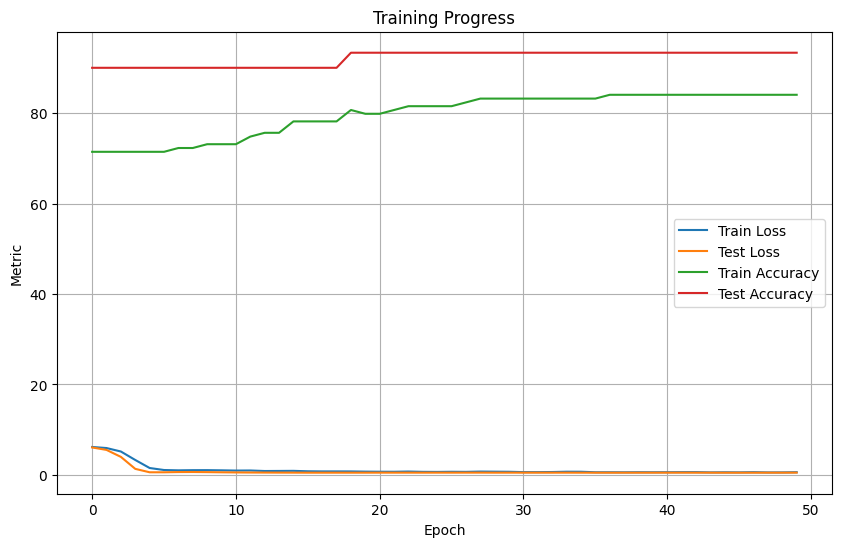

Evaluation Loss: 0.503205, Accuracy: 93.33%
Evaluation Loss: 0.503205, Accuracy: 93.33%
Model saved to models_4L_50ep/ABS_0.pth
Epoch 1 | Train Loss: 6.175234, Train Acc: 76.47% | Test Loss: 6.114457, Test Acc: 70.00%
Epoch 2 | Train Loss: 5.912646, Train Acc: 76.47% | Test Loss: 5.704439, Test Acc: 70.00%
Epoch 3 | Train Loss: 5.174959, Train Acc: 76.47% | Test Loss: 4.538837, Test Acc: 70.00%
Epoch 4 | Train Loss: 3.119186, Train Acc: 76.47% | Test Loss: 2.417321, Test Acc: 70.00%
Epoch 5 | Train Loss: 1.305983, Train Acc: 76.47% | Test Loss: 1.431583, Test Acc: 70.00%
Epoch 6 | Train Loss: 0.934433, Train Acc: 76.47% | Test Loss: 1.245031, Test Acc: 70.00%
Epoch 7 | Train Loss: 0.927885, Train Acc: 76.47% | Test Loss: 1.236807, Test Acc: 70.00%
Epoch 8 | Train Loss: 0.961972, Train Acc: 77.31% | Test Loss: 1.223141, Test Acc: 73.33%
Epoch 9 | Train Loss: 0.891978, Train Acc: 77.31% | Test Loss: 1.187860, Test Acc: 73.33%
Epoch 10 | Train Loss: 0.828059, Train Acc: 77.31% | Test Loss

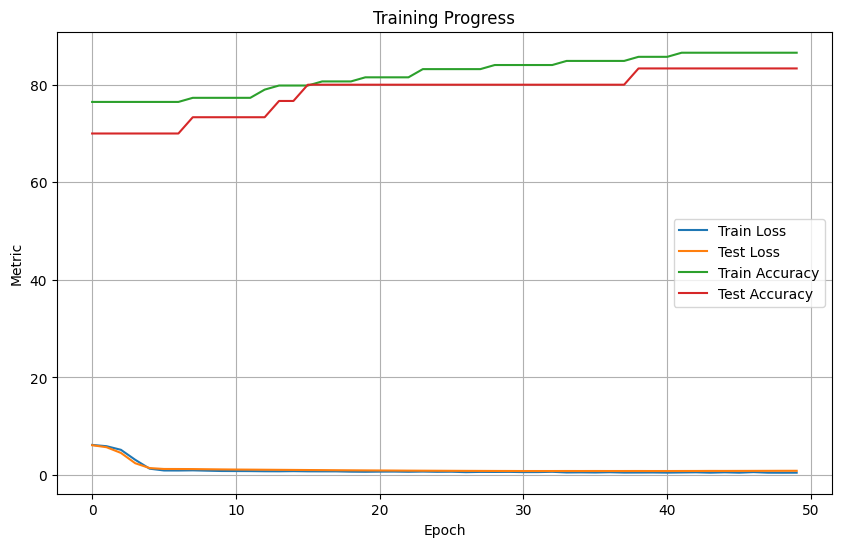

Evaluation Loss: 0.872506, Accuracy: 83.33%
Evaluation Loss: 0.872506, Accuracy: 83.33%
Model saved to models_4L_50ep/ABS_1.pth
Epoch 1 | Train Loss: 6.177949, Train Acc: 75.63% | Test Loss: 6.100354, Test Acc: 73.33%
Epoch 2 | Train Loss: 5.912953, Train Acc: 74.79% | Test Loss: 5.650451, Test Acc: 73.33%
Epoch 3 | Train Loss: 5.146062, Train Acc: 75.63% | Test Loss: 4.361008, Test Acc: 73.33%
Epoch 4 | Train Loss: 3.111388, Train Acc: 75.63% | Test Loss: 2.084564, Test Acc: 73.33%
Epoch 5 | Train Loss: 1.399338, Train Acc: 75.63% | Test Loss: 1.183394, Test Acc: 73.33%
Epoch 6 | Train Loss: 0.963474, Train Acc: 75.63% | Test Loss: 1.043889, Test Acc: 73.33%
Epoch 7 | Train Loss: 1.002357, Train Acc: 75.63% | Test Loss: 1.051201, Test Acc: 73.33%
Epoch 8 | Train Loss: 0.974100, Train Acc: 76.47% | Test Loss: 1.046883, Test Acc: 73.33%
Epoch 9 | Train Loss: 0.919398, Train Acc: 77.31% | Test Loss: 1.023932, Test Acc: 73.33%
Epoch 10 | Train Loss: 0.909669, Train Acc: 77.31% | Test Loss

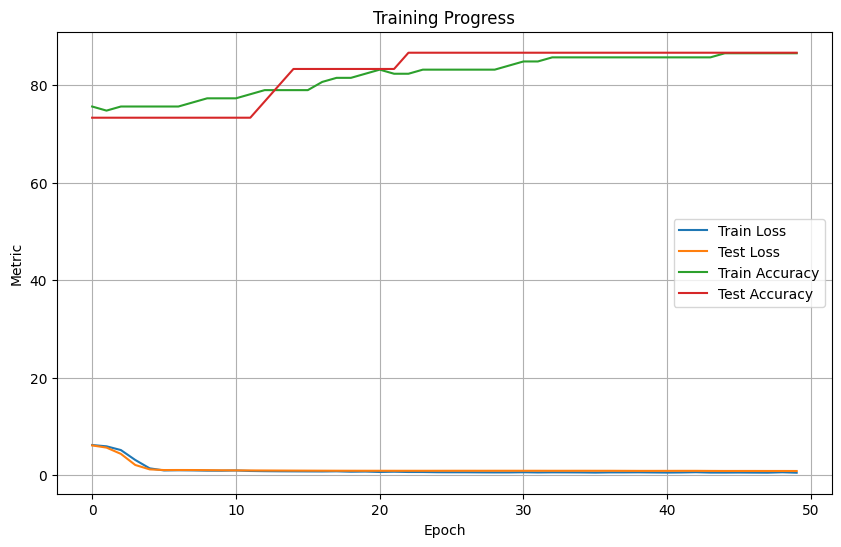

Evaluation Loss: 0.848694, Accuracy: 86.67%
Evaluation Loss: 0.848694, Accuracy: 86.67%
Model saved to models_4L_50ep/ABS_2.pth
Epoch 1 | Train Loss: 6.181072, Train Acc: 75.63% | Test Loss: 6.080420, Test Acc: 73.33%
Epoch 2 | Train Loss: 5.938672, Train Acc: 75.63% | Test Loss: 5.570804, Test Acc: 73.33%
Epoch 3 | Train Loss: 5.170168, Train Acc: 75.63% | Test Loss: 4.123690, Test Acc: 73.33%
Epoch 4 | Train Loss: 3.375238, Train Acc: 75.63% | Test Loss: 1.701422, Test Acc: 73.33%
Epoch 5 | Train Loss: 1.493703, Train Acc: 75.63% | Test Loss: 1.101308, Test Acc: 73.33%
Epoch 6 | Train Loss: 0.949152, Train Acc: 75.63% | Test Loss: 1.032017, Test Acc: 73.33%
Epoch 7 | Train Loss: 1.172331, Train Acc: 75.63% | Test Loss: 1.035127, Test Acc: 73.33%
Epoch 8 | Train Loss: 0.964448, Train Acc: 76.47% | Test Loss: 1.023180, Test Acc: 76.67%
Epoch 9 | Train Loss: 0.880358, Train Acc: 76.47% | Test Loss: 1.008841, Test Acc: 76.67%
Epoch 10 | Train Loss: 0.887163, Train Acc: 76.47% | Test Loss

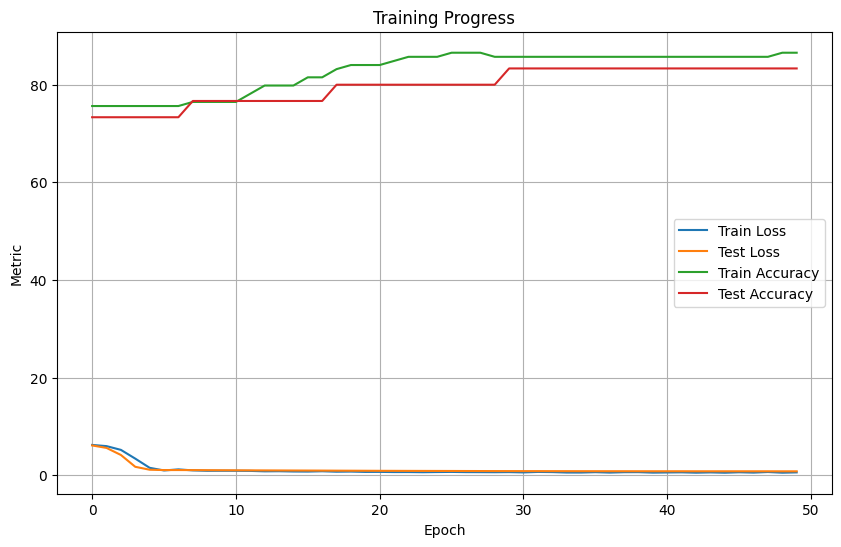

Evaluation Loss: 0.776007, Accuracy: 83.33%
Evaluation Loss: 0.776007, Accuracy: 83.33%
Model saved to models_4L_50ep/ABS_3.pth
Epoch 1 | Train Loss: 6.175304, Train Acc: 73.95% | Test Loss: 6.094640, Test Acc: 80.00%
Epoch 2 | Train Loss: 5.951153, Train Acc: 73.95% | Test Loss: 5.625619, Test Acc: 80.00%
Epoch 3 | Train Loss: 5.198667, Train Acc: 73.95% | Test Loss: 4.278880, Test Acc: 80.00%
Epoch 4 | Train Loss: 3.369722, Train Acc: 73.95% | Test Loss: 1.894645, Test Acc: 80.00%
Epoch 5 | Train Loss: 1.461624, Train Acc: 73.95% | Test Loss: 1.026048, Test Acc: 80.00%
Epoch 6 | Train Loss: 1.001094, Train Acc: 73.95% | Test Loss: 0.844842, Test Acc: 80.00%
Epoch 7 | Train Loss: 1.002723, Train Acc: 73.95% | Test Loss: 0.809006, Test Acc: 80.00%
Epoch 8 | Train Loss: 0.983322, Train Acc: 74.79% | Test Loss: 0.794053, Test Acc: 80.00%
Epoch 9 | Train Loss: 0.975184, Train Acc: 75.63% | Test Loss: 0.782439, Test Acc: 80.00%
Epoch 10 | Train Loss: 0.919483, Train Acc: 75.63% | Test Loss

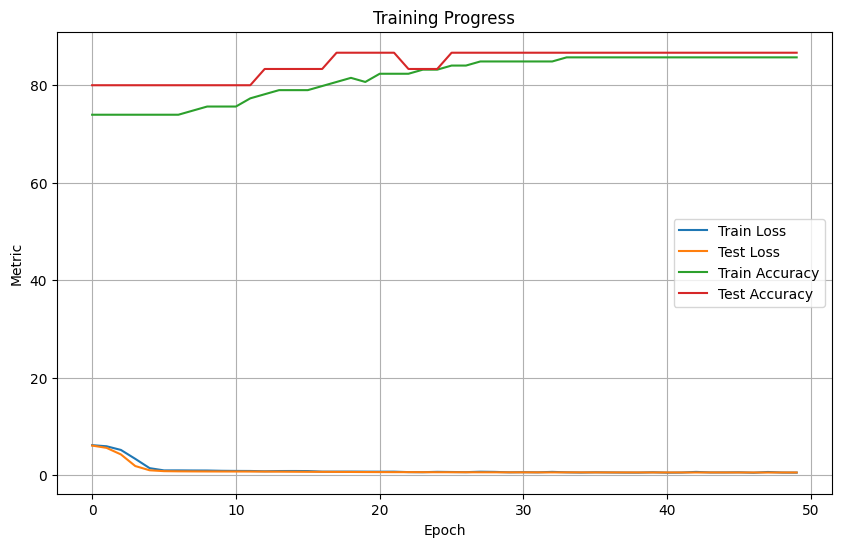

Evaluation Loss: 0.572584, Accuracy: 86.67%
Evaluation Loss: 0.572584, Accuracy: 86.67%
Model saved to models_4L_50ep/ABS_4.pth


In [35]:
evaluate_list = []
# for num_layers in range(6, 11):
for num_model in range(5):
    X = []
    y = []
    for i in range(len(data_dicts)):
        X.append([j for j in data_dicts[i]['input'].values()])
        y.append(dec_to_countsVec(int(data_dicts[i]['target'], 2), n, 10240))

    X = np.array(X)
    X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    y = np.array(y)
    y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Automatically extract input/output dimensions from the dataset
    input_dim = X_tensor.shape[1]
    output_dim = y_tensor.shape[1]

    # Initialize kernel
    # kernel = [0] * (n+1)
    # kernel[0] = avg[0]
    # for i in range(1, len(kernel)):
    #     kernel[i] = avg[1]
    # kernel = [random.uniform(0.1, 1.0) for _ in range(n+1)]
        
    num_layers = 4  # Define the number of convolutional layers

    # Initialize kernel list with average hamming distance weight 
    kernel_list = [kernel] * num_layers
    # kernel_list = [[random.uniform(0.1, 1.0) for _ in range(n+1)] for _ in range(num_layers)] # for random initialization

    # Create the model and move it to GPU
    model = HammingConvModel(input_dim, output_dim, num_layers, kernel_list).to('cuda')

    # Train the model
    model.train_model(train_loader, test_loader, learning_rate=0.01, epochs=50)

    file_path = f"models_4L_50ep/ABS_{num_model}.pth"
    model.evaluate(test_loader)
    evaluate_list.append(model.evaluate(test_loader))
    save_model(model, file_path)

In [52]:
def evaluate_tensor(model, X_tensor, y_tensor):
    """Evaluate the model directly on X_tensor and y_tensor without DataLoader, showing top 10 closest predictions."""
    model.eval()
    X_tensor, y_tensor = X_tensor.to('cuda'), y_tensor.to('cuda')
    
    with torch.no_grad():
        predicted_output = model(X_tensor)
        predicted_indices = torch.argmax(predicted_output, dim=1).cpu().numpy()
        true_indices = torch.argmax(y_tensor, dim=1).cpu().numpy()
        
        print("Predictions (Bit Strings & Decimal, Top 10 Closest):")
        for i, idx in enumerate(predicted_indices):
            top_10_indices = torch.topk(predicted_output[i], 10).indices.cpu().numpy()
            top_10_bit_strings = [format(t, '09b') for t in top_10_indices]
            top_10_decimals = [str(t) for t in top_10_indices]
            print(f"Predicted: {format(idx, '09b')} (Decimal: {idx})")
            print(f"Top 10 Closest: {', '.join(top_10_bit_strings)} (Decimals: {', '.join(top_10_decimals)})")

        print("True Values (Bit Strings & Decimal):")
        for idx in true_indices:
            bit_str = format(idx, '09b')
            print(f"{bit_str} (Decimal: {idx})")
        
        # Compute accuracy
        correct_predictions = (predicted_indices == true_indices).sum()
        total_samples = y_tensor.size(0)
    
    pred = predicted_output.cpu().numpy()
    true = y_tensor.cpu().numpy()
    fidelities = [fid_class(p, t) for p, t in zip(pred, true)]
    accuracy = correct_predictions / total_samples
    print(f"Accuracy: {correct_predictions / total_samples:.2f}%")
    print("-" * 50)
    return accuracy, predicted_output, fidelities

In [ ]:
evaluate_list

In [ ]:
avg_loss = 0
avg_acc = 0
for i in evaluate_list:
    avg_loss += i[0]
    avg_acc += i[1]

avg_loss = avg_loss/len(evaluate_list)
avg_acc = avg_acc/len(evaluate_list)

(avg_loss, avg_acc)


Run with He initialization

In [ ]:
evaluate_list = []
# for num_layers in range(6, 11):
for num_model in range(5):
    X = []
    y = []
    for i in range(len(data_dicts)):
        X.append([j for j in data_dicts[i]['input'].values()])
        y.append(dec_to_countsVec(int(data_dicts[i]['target'], 2), n, 10240))

    X = np.array(X)
    X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    y = np.array(y)
    y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Automatically extract input/output dimensions from the dataset
    input_dim = X_tensor.shape[1]
    output_dim = y_tensor.shape[1]

    # Initialize kernel
    std = math.sqrt(2.0 / (n+1))
    # kernel = [0] * (n+1)
    # kernel[0] = avg[0]
    # for i in range(1, len(kernel)):
    #     kernel[i] = avg[1]
    kernel = [random.gauss(0, std) for _ in range(n+1)]
        
    num_layers = 5  # Define the number of convolutional layers

    # Initialize kernel list with average hamming distance weight 
    kernel_list = [kernel] * num_layers
    
    # Create the model and move it to GPU
    model = HammingConvModel(input_dim, output_dim, num_layers, kernel_list).to('cuda')

    # Train the model
    model.train_model(train_loader, learning_rate=0.01, epochs=50)

    file_path = f"models_He/ABS_{num_model}.pth"
    model.evaluate(test_loader)
    evaluate_list.append(model.evaluate(test_loader))
    save_model(model, file_path)

In [ ]:
evaluate_list

In [ ]:
avg_loss = 0
avg_acc = 0
for i in evaluate_list:
    avg_loss += i[0]
    avg_acc += i[1]

avg_loss = avg_loss/len(evaluate_list)
avg_acc = avg_acc/len(evaluate_list)

(avg_loss, avg_acc)

Test with different data

In [75]:
n=9
key_list = []
result_bank = []

file_name = f'1_7-ones_9qubitsBV.csv'
with open(file_name, 'r', newline='') as csvfile:
    resultDict = newResultDict("0" * n)
    reader = csv.DictReader(csvfile, fieldnames = resultDict.keys())
    for row in reader:
        key_list.append(row['secret_string'])
        result_bank.append({k: int(v) for k, v in list(row.items())[1:]})

data_dicts = []
for i in range(len(key_list)):
    temp = {}
    temp["input"] = result_bank[i]
    temp["target"] = key_list[i]
    data_dicts.append(temp)


In [76]:
data_dicts = data_dicts[::-1]

In [77]:
rank_list_b4 = []
for i in range(len(data_dicts)):
    rank_list_b4.append(get_rank(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list_b4 = np.array(rank_list_b4)
rank_list_b4

array([ 1,  1,  1,  1,  1,  7,  2,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 30, 15, 11,  1, 19,  7,  2,  2, 29,  2, 15,  2,  1,
        1,  1,  1, 18, 13,  4,  1,  3,  5,  2,  1,  5,  1,  7,  1,  1,  1,
        1,  1, 50, 26,  1,  1,  3,  1,  2,  1,  3,  1,  5,  1,  1,  1,  1,
        1, 52,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       65,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  4,  1,  1,  1,  1,
        1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [78]:
X = []
y = []
for i in range(len(data_dicts)):
    X.append([j for j in data_dicts[i]['input'].values()])
    y.append(data_dicts[i]['target'])

X = np.array(X)
X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
X_tensor = torch.tensor(X, dtype=torch.float32)
target_bits = copy.deepcopy(y)

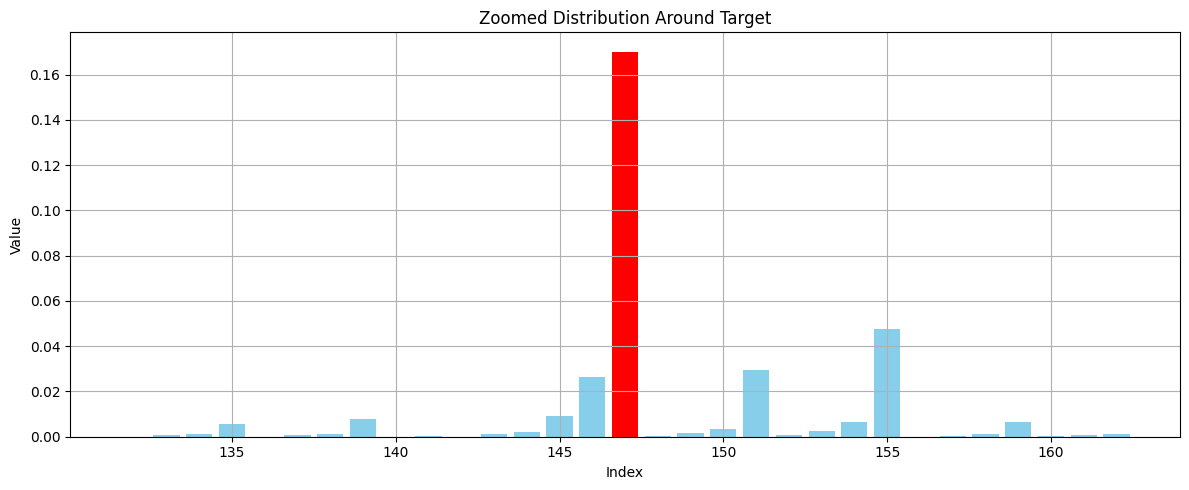

In [79]:
plot_distribution(X[1], int(y[1], 2))

In [80]:
original_predict = []
for i in range(len(X_tensor)):
    predicted_string = predict_binary_string(X_tensor[i], num_qubits=9)
    original_predict.append(predicted_string)
calculate_accuracy(original_predict, y)

0.7516778523489933

In [81]:
for i in range(len(y)):
    y[i] = dec_to_countsVec(int(y[i],2), n, 10240)

y = np.array(y)
y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
y_tensor = torch.tensor(y, dtype=torch.float32)

In [82]:
pred = X_tensor.cpu().numpy()
true = y_tensor.cpu().numpy()
fidelities = [fid_class(p, t) for p, t in zip(pred, true)]

In [83]:
fidelities = np.array(fidelities)
average_fid = np.mean(fidelities)
average_fid

np.float32(0.5967754)

In [84]:
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]

In [85]:
kernel = [0] * (n+1)
kernel[0] = avg[0]
for i in range(1, len(kernel)):
    kernel[i] = avg[1]
    
# Extract input and output dimensions
input_dim = X_tensor.shape[1]  # 512
output_dim = y_tensor.shape[1]  # 512
num_layers = 4  # Define the number of convolutional layers

# Initialize kernel with average hamming distance weight 
kernel_list = [kernel] * num_layers

In [98]:
accuracy_list = []
for i in range(5):
    model = load_model(HammingConvModel, input_dim, output_dim, num_layers, kernel_list, f"models/ABS_4L_{i}.pth")
    accuracy_list.append(evaluate_tensor(model, X_tensor, y_tensor)[0])
    predicted_output = evaluate_tensor(model, X_tensor, y_tensor)[1]
    fidelities = evaluate_tensor(model, X_tensor, y_tensor)[2]
    predicted_output = predicted_output.cpu().numpy()
    predicted_output = np.array(predicted_output)

/tmp/ipykernel_354283/2968998948.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel = nn.Parameter(torch.tensor(kernel, dtype=torch.float32, device='cuda'))


Model loaded from models/ABS_4L_0.pth
Predictions (Bit Strings & Decimal, Top 10 Closest):
Predicted: 010010100 (Decimal: 148)
Top 10 Closest: 010010100, 110110100, 111010100, 011110100, 110010100, 010110100, 010010110, 010011100, 011010100, 110011100 (Decimals: 148, 436, 468, 244, 404, 180, 150, 156, 212, 412)
Predicted: 010010011 (Decimal: 147)
Top 10 Closest: 010010011, 011010011, 010110011, 010011011, 110010011, 011110011, 111010011, 010010111, 110110011, 011011011 (Decimals: 147, 211, 179, 155, 403, 243, 467, 151, 435, 219)
Predicted: 010010010 (Decimal: 146)
Top 10 Closest: 010010010, 110110010, 111010010, 110010010, 011110010, 010110010, 010011010, 011010010, 010010001, 010010110 (Decimals: 146, 434, 466, 402, 242, 178, 154, 210, 145, 150)
Predicted: 010010001 (Decimal: 145)
Top 10 Closest: 010010001, 110110001, 111010001, 110010001, 010110001, 011110001, 010011001, 011010001, 010010101, 010010011 (Decimals: 145, 433, 465, 401, 177, 241, 153, 209, 149, 147)
Predicted: 010010000 

In [99]:
accuracy_list = np.array(accuracy_list)
avg_acc = np.average(accuracy_list)
avg_acc

np.float64(0.8590604026845637)

In [100]:
accuracy_list

array([0.86577181, 0.85234899, 0.86577181, 0.85234899, 0.8590604 ])

In [101]:
model = load_model(HammingConvModel, input_dim, output_dim, num_layers, kernel_list, f"models/ABS_4L_{0}.pth")
predicted_output = evaluate_tensor(model, X_tensor, y_tensor)[1]
fidelities = evaluate_tensor(model, X_tensor, y_tensor)[2]
predicted_output = predicted_output.cpu().numpy()
predicted_output = np.array(predicted_output)

Model loaded from models/ABS_4L_0.pth


/tmp/ipykernel_354283/2968998948.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel = nn.Parameter(torch.tensor(kernel, dtype=torch.float32, device='cuda'))


Predictions (Bit Strings & Decimal, Top 10 Closest):
Predicted: 010010100 (Decimal: 148)
Top 10 Closest: 010010100, 110110100, 111010100, 011110100, 110010100, 010110100, 010010110, 010011100, 011010100, 110011100 (Decimals: 148, 436, 468, 244, 404, 180, 150, 156, 212, 412)
Predicted: 010010011 (Decimal: 147)
Top 10 Closest: 010010011, 011010011, 010110011, 010011011, 110010011, 011110011, 111010011, 010010111, 110110011, 011011011 (Decimals: 147, 211, 179, 155, 403, 243, 467, 151, 435, 219)
Predicted: 010010010 (Decimal: 146)
Top 10 Closest: 010010010, 110110010, 111010010, 110010010, 011110010, 010110010, 010011010, 011010010, 010010001, 010010110 (Decimals: 146, 434, 466, 402, 242, 178, 154, 210, 145, 150)
Predicted: 010010001 (Decimal: 145)
Top 10 Closest: 010010001, 110110001, 111010001, 110010001, 010110001, 011110001, 010011001, 011010001, 010010101, 010010011 (Decimals: 145, 433, 465, 401, 177, 241, 153, 209, 149, 147)
Predicted: 010010000 (Decimal: 144)
Top 10 Closest: 0100100

In [102]:
predicted_output

array([[5.5365060e-22, 1.7245242e-22, 1.9647710e-22, ..., 5.5317047e-25,
        7.3839920e-25, 1.5709796e-25],
       [4.8160664e-10, 2.2543116e-09, 4.1309680e-09, ..., 2.4057099e-13,
        3.1901131e-13, 3.0940302e-12],
       [3.8180656e-23, 3.2834025e-23, 2.3371487e-19, ..., 1.0090834e-26,
        4.4740431e-26, 1.1567079e-26],
       ...,
       [2.6423620e-13, 7.5776625e-13, 1.0000000e+00, ..., 2.2229564e-33,
        2.2473591e-33, 2.2229564e-33],
       [5.8257522e-13, 1.0000000e+00, 3.4221191e-13, ..., 1.5382873e-34,
        1.5382873e-34, 1.5382873e-34],
       [1.0000000e+00, 2.4589538e-12, 1.2376996e-12, ..., 3.4508565e-34,
        3.4508565e-34, 3.4508565e-34]], dtype=float32)

In [103]:
for i in range(len(data_dicts)):
    keys = list(data_dicts[i]["input"].keys())  # preserves key order
    values = predicted_output[i]
    data_dicts[i]["input"] = dict(zip(keys, values))

In [104]:
rank_list_after = []
for i in range(len(data_dicts)):
    rank_list_after.append(get_rank(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list_after = np.array(rank_list_after)
rank_list_after

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 19,  4,  2,  1, 12,  1,  1,  1, 11,  1,  2,  1,  1,
        1,  1,  1,  2,  4,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 61,  7,  1,  1,  1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,
        1, 17,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       13,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,
        1,  1,  1,  7,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [105]:
increase = 0
decrease = 0
for i in range(len(rank_list_b4)):
    if rank_list_b4[i] < rank_list_after[i]:
        decrease += 1
    if rank_list_b4[i] > rank_list_after[i]:
        increase += 1
increase, decrease

(34, 2)

In [106]:
fidelities = np.array(fidelities)
average_fid = np.mean(fidelities)
average_fid

np.float32(0.87582344)

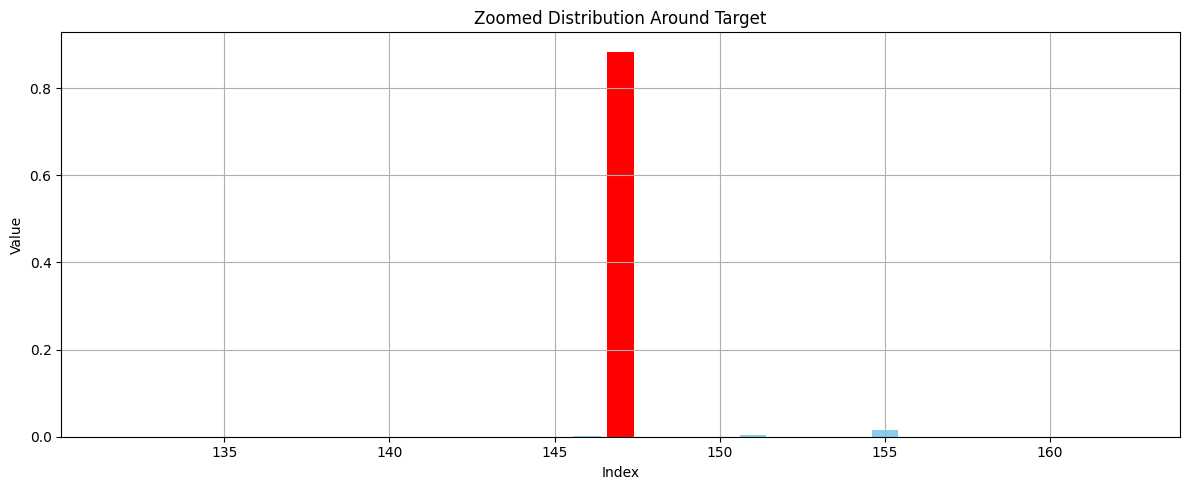

In [107]:
plot_distribution(predicted_output[1], int(target_bits[1], 2))

In [113]:
def evaluate_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(y_batch, dim=1)  # assuming y_batch is one-hot

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

In [114]:
evaluate_metrics(model, test_loader)

Precision: 0.7727272727272727
Recall: 0.7878787878787878
F1 Score: 0.7777777777777777
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
